# Hugging face

/home/byeooon/.conda/envs/wheel_loader/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


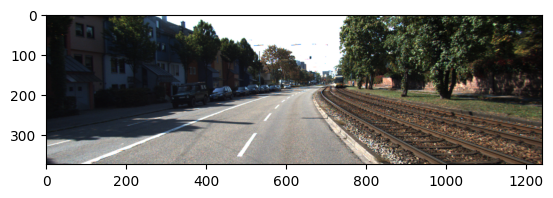

In [2]:

import io
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from transformers import AutoImageProcessor, AutoModel

img = Image.open('kitti_img.png')
img2np = np.array(img)

plt.imshow(img2np) ## 행렬 이미지를 다시 이미지로 변경해 디스플레이
plt.show() ## 이미지 인터프린터에 출력

processor = AutoImageProcessor.from_pretrained('facebook/dinov2-giant', crop_size={'height':644, 'width':644}, size={'height':644, 'width':644})
model = AutoModel.from_pretrained('facebook/dinov2-giant')

inputs = processor(images=img2np, return_tensors="pt")
outputs = model(**inputs)
last_hidden_states = outputs.last_hidden_state

output_size = int(inputs.pixel_values[0].shape[1]/14)

In [7]:
last_hidden_states.shape

torch.Size([1, 2210, 1536])

In [17]:
from numpy.linalg import norm

idx = 1350
mean = last_hidden_states[0][idx].detach().numpy()

cosine_sim = np.dot(last_hidden_states[0].detach().numpy(), mean) / (norm(last_hidden_states[0].detach().numpy())*norm(mean))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


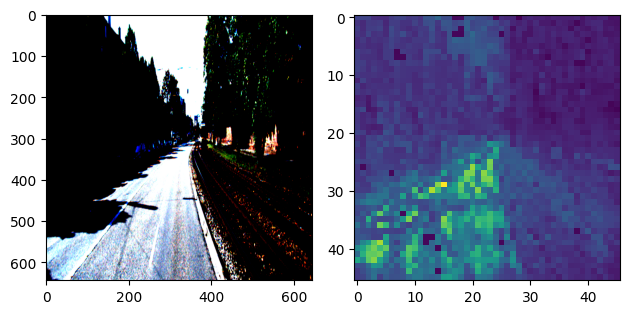

In [18]:
norm_cosine = cosine_sim/np.max(cosine_sim)

plt.subplot(1,2,1)
plt.imshow(inputs.pixel_values[0].permute(1,2,0))
plt.subplot(1,2,2)
plt.imshow(norm_cosine[1:].reshape((output_size, output_size)))
# plt.colorbar()
plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


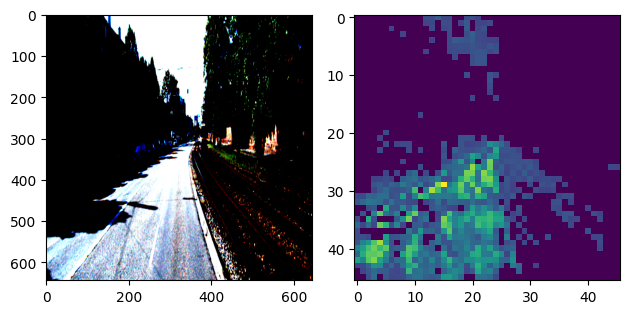

In [19]:
norm_cosine[np.where(norm_cosine<0.2)[0]] = 0

plt.subplot(1,2,1)
plt.imshow(inputs.pixel_values[0].permute(1,2,0))
plt.subplot(1,2,2)
plt.imshow(norm_cosine[1:].reshape((output_size, output_size)))
# plt.colorbar()
plt.tight_layout()
plt.show()

# Github

In [3]:
import torch
import os
import sys

os.environ["XFORMERS_DISABLED"] = "1" # Switch to enable xFormers

dinov2_vitg14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitg14')

Using cache found in /home/byeooon/.cache/torch/hub/facebookresearch_dinov2_main
/home/byeooon/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:45: UserWarning: xFormers is disabled (SwiGLU)
  warnings.warn("xFormers is disabled (SwiGLU)")
/home/byeooon/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/byeooon/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:29: UserWarning: xFormers is disabled (Attention)
  warnings.warn("xFormers is disabled (Attention)")
/home/byeooon/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/byeooon/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:35: UserWarning: xFormers is disabled (Block)
  warnings.warn("xFormer

In [4]:
from numpy.linalg import norm

idx = 2000
mean = dinov2_vitg14.get_intermediate_layers(inputs.pixel_values)[0][0][idx].detach().numpy()

cosine_sim = np.dot(last_hidden_states[0].detach().numpy(), mean) / (norm(last_hidden_states[0].detach().numpy())*norm(mean))

In [5]:
cosine_sim.shape

(2117,)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


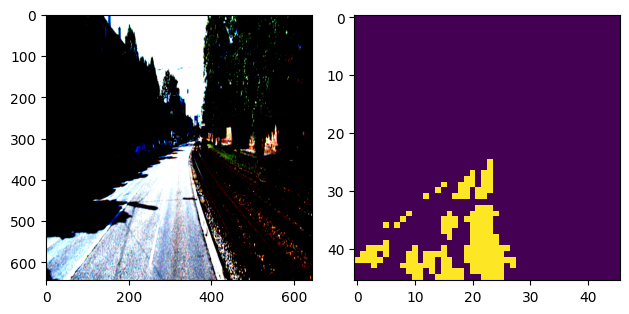

In [5]:
norm_cosine = cosine_sim/np.max(cosine_sim)
norm_cosine[np.where(norm_cosine<0.4)[0]] = 0
norm_cosine[np.where(norm_cosine>=0.4)[0]] = 1

plt.subplot(1,2,1)
plt.imshow(inputs.pixel_values[0].permute(1,2,0))
plt.subplot(1,2,2)
plt.imshow(norm_cosine[1:].reshape((output_size, output_size)))
# plt.colorbar()
plt.tight_layout()
plt.show()

In [6]:
import numpy as np
import pydensecrf.densecrf as dcrf
import cv2

norm_cosine = norm_cosine[1:].reshape((46, 46))
norm_cosine = cv2.resize(norm_cosine, (644, 644))



In [7]:
from pydensecrf.densecrf import ConstUnary

In [19]:
d = dcrf.DenseCRF2D(644, 644, 2)  # width, height, nlabels

# inputs2np = np.array(inputs.pixel_values[0,:,:,:])
origin_input = cv2.imread('kitti_img.png')
origin_input = cv2.resize(origin_input, (644,644))



U = norm_cosine.reshape(2,-1)
# d.setUnaryEnergy(U)
d.setUnary(ConstUnary(U))

d.addPairwiseGaussian(sxy=5, compat=3)
d.addPairwiseBilateral(sxy=25, srgb=3, rgbim=origin_input, compat=10)



In [21]:

Q = d.inference(10)

map = np.argmax(Q, axis=0).reshape((322,322))
proba = np.array(Q)

ValueError: cannot reshape array of size 207368 into shape (322,322)

In [18]:
U.min()

0.0